# **Analysis of decoding results**

## **Libraries**

In [63]:
#%pip install pandas matplotlib seaborn nltk sacrebleu

In [64]:
import os
import warnings

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import nltk
import sacrebleu

import constants

## **Directories**

In [65]:
RESULTS_FOLDER = constants.RESULTS_DATA_FOLDER
INSPECTED_FOLDER = constants.INSPECTED_DATA_FOLDER

DECODED_OUTPUTS_FILENAME = 'split_decode_checkpoint_100-80.log'#'first_decode_checkpoint_100-50.log'#
DECODED_OUTPUTS_FILEPATH = os.path.join(INSPECTED_FOLDER, DECODED_OUTPUTS_FILENAME)
REFERENCE_SOURCE_FILENAME = 'valid_gn.txt.gn' #'first_val_gn.txt'#
REFERENCE_SOURCE_FILEPATH = os.path.join(INSPECTED_FOLDER, REFERENCE_SOURCE_FILENAME)
REFERENCE_DESTINATION_FILENAME = 'valid_es.txt.es' #'first_val_es.txt'#
REFERENCE_DESTINATION_FILEPATH = os.path.join(INSPECTED_FOLDER, REFERENCE_DESTINATION_FILENAME)
FIRST_DECODING_RESULTS_FOLDER = os.path.join(RESULTS_FOLDER, 'first_decode_checkpoint_100-50')
CURRENT_RESULTS_FOLDER = os.path.join(FIRST_DECODING_RESULTS_FOLDER, DECODED_OUTPUTS_FILENAME.split('.')[0])

if not os.path.exists(FIRST_DECODING_RESULTS_FOLDER):
    os.makedirs(FIRST_DECODING_RESULTS_FOLDER)

if not os.path.exists(CURRENT_RESULTS_FOLDER):
    os.makedirs(CURRENT_RESULTS_FOLDER)

In [66]:
with open(REFERENCE_SOURCE_FILEPATH, 'r', encoding='utf-8') as f:
    reference_source_gn = f.readlines()

with open(REFERENCE_DESTINATION_FILEPATH, 'r', encoding='utf-8') as f:
    reference_destination_es = f.readlines()

with open(DECODED_OUTPUTS_FILEPATH, 'r', encoding='utf-8') as f:
    decoded_outputs = f.readlines()

## **Checking files**

In [67]:
print(f'Number of lines in reference source: {len(reference_source_gn)}')
print(f'Number of lines in reference destination: {len(reference_destination_es)}')
print(f'Number of lines in decoded outputs: {len(decoded_outputs)}')

Number of lines in reference source: 4939
Number of lines in reference destination: 4939
Number of lines in decoded outputs: 4938


There is a difference of 1 between the number of lines in the decoded outputs and the number of lines in the original inputs.

In [68]:
for idx, (elem_ref, elem_dest, decoded) in enumerate(zip(reference_source_gn, reference_destination_es, decoded_outputs)):
    if elem_ref.strip() == '':
        print(f'Empty line at index {idx} from reference source')

    if elem_dest.strip() == '':
        print(f'Empty line at index {idx} from reference destination')

    if decoded.strip() == '':
        print(f'Empty line at index {idx} from decoded outputs')

Empty line at index 1188 from decoded outputs


This extra line is not a problem, as the decoded file can output empty lines. However, it remains unclear why the length of the files are different.

## **Score analysis**

### **Examples of BLEU score**

In [69]:
def silence_warnings(func):
    def wrapper(*args, **kwargs):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            return func(*args, **kwargs)
    return wrapper

In [70]:
correct_reference = ['Today', 'is', 'a', 'new', 'day']
short_reference = ['Today']
wrong_reference = ['Yesterday', 'was', 'a', 'good', 'day']

translated = ['Today', 'is', 'a', 'new', 'day']

### **Classic BLEU**

In [71]:
@silence_warnings
def calculate_bleu(reference, translated, bleu_score_type='classic'):
    classic_bleu_function = lambda reference, translated: nltk.translate.bleu_score.sentence_bleu([reference], translated)
    one_gram_bleu_function = lambda reference, translated: nltk.translate.bleu_score.sentence_bleu([reference], translated, weights=(4, 0, 0, 0))
    sacrebleu_function = lambda reference, translated: sacrebleu.corpus_bleu([' '.join(translated)], [[' '.join(reference)]]).score
    
    score_functions = {
        'classic': classic_bleu_function,
        'one-gram': one_gram_bleu_function,
        'sacrebleu': sacrebleu_function
    }

    bleu_score = score_functions[bleu_score_type](reference, translated)
    return bleu_score

In [72]:
def create_bleu_scores_df(references, translated, bleu_score_types):
    bleu_scores_df = {'reference': [], 'translation': [], 'metric': [], 'score': []}

    for reference, translation in zip(references, translated):
        for bleu_score_type in bleu_score_types:
            bleu_score = calculate_bleu(reference, translation, bleu_score_type=bleu_score_type)
            bleu_scores_df['reference'].append(' '.join(reference))
            bleu_scores_df['translation'].append(' '.join(translation))
            bleu_scores_df['metric'].append(bleu_score_type)
            bleu_scores_df['score'].append(bleu_score)

    return pd.DataFrame(bleu_scores_df)

In [73]:
example_dfs = []

example_references = [correct_reference, short_reference, wrong_reference]
bleu_scores_example_df = create_bleu_scores_df(example_references, [translated]*len(example_references), bleu_score_types=['classic', 'one-gram', 'sacrebleu'])
example_dfs.append(bleu_scores_example_df)

example_dfs = pd.concat(example_dfs)
example_dfs.style.format({'score': '{:.5g}'})

,reference,translation,metric,score
0,Today is a new day,Today is a new day,classic,1
1,Today is a new day,Today is a new day,one-gram,1
2,Today is a new day,Today is a new day,sacrebleu,100
3,Today,Today is a new day,classic,1.2183e-231
4,Today,Today is a new day,one-gram,0.0016
5,Today,Today is a new day,sacrebleu,10.682
6,Yesterday was a good day,Today is a new day,classic,1.4488e-231
7,Yesterday was a good day,Today is a new day,one-gram,0.0256
8,Yesterday was a good day,Today is a new day,sacrebleu,12.703


### **BLEU score distribution**

In [74]:
tokenized_reference_destination_es = [reference.split() for reference in reference_destination_es]
tokenized_decoded_outputs = [decoded.split() for decoded in decoded_outputs]
bleu_scores_df = create_bleu_scores_df(tokenized_reference_destination_es, tokenized_decoded_outputs, bleu_score_types=['classic', 'one-gram', 'sacrebleu'])

In [75]:
save_path = os.path.join(CURRENT_RESULTS_FOLDER, 'bleu_scores.csv')
bleu_scores_df.to_csv(save_path, index=False)

In [76]:
for metric in bleu_scores_df['metric'].unique():
    print(f'Metric: {metric}')
    print(bleu_scores_df[bleu_scores_df['metric'] == metric].describe())
    print()

save_path = os.path.join(CURRENT_RESULTS_FOLDER, 'bleu_scores_summary.csv')
bleu_scores_df.groupby(['metric']).describe().to_csv(save_path)

Metric: classic
               score
count   4.938000e+03
mean    2.889436e-03
std     3.332824e-02
min     0.000000e+00
25%     0.000000e+00
50%    8.724164e-232
75%    1.218332e-231
max     1.000000e+00

Metric: one-gram
             score
count  4938.000000
mean      0.004363
std       0.035034
min       0.000000
25%       0.000000
50%       0.000336
75%       0.001717
max       1.000000

Metric: sacrebleu
             score
count  4938.000000
mean      2.788026
std       4.508518
min       0.000000
25%       1.128678
50%       1.996819
75%       3.178347
max     100.000000



This does not align with the BLEU score returned by marian.

TODO: Sentences shorter than 4 words are not well-suited for BLEU scoring.

In [77]:
bleu_classic_scores = bleu_scores_df[bleu_scores_df['metric'] == 'classic']['score']
sacrebleu_scores = bleu_scores_df[bleu_scores_df['metric'] == 'sacrebleu']['score']

In [78]:
def plot_scores(scores, titles, xlabel, save_path=None):
    fig, ax = plt.subplots(nrows=1, ncols=len(scores), figsize=(15, 5))
    sns.set_style('darkgrid')
    for idx, (score, title) in enumerate(zip(scores, titles)):
        current_ax = ax[idx] if len(scores) > 1 else ax
        sns.kdeplot(score, fill=True, ax=current_ax)
        current_ax.set(xlabel=xlabel, ylabel='Density', title=title)

    if save_path is not None:
        plt.savefig(save_path)
        sns.set_style('darkgrid')

Number of positive BLEU scores: 4938
Number of non-negligible BLEU scores: 73
Number of acceptable BLEU scores: 13


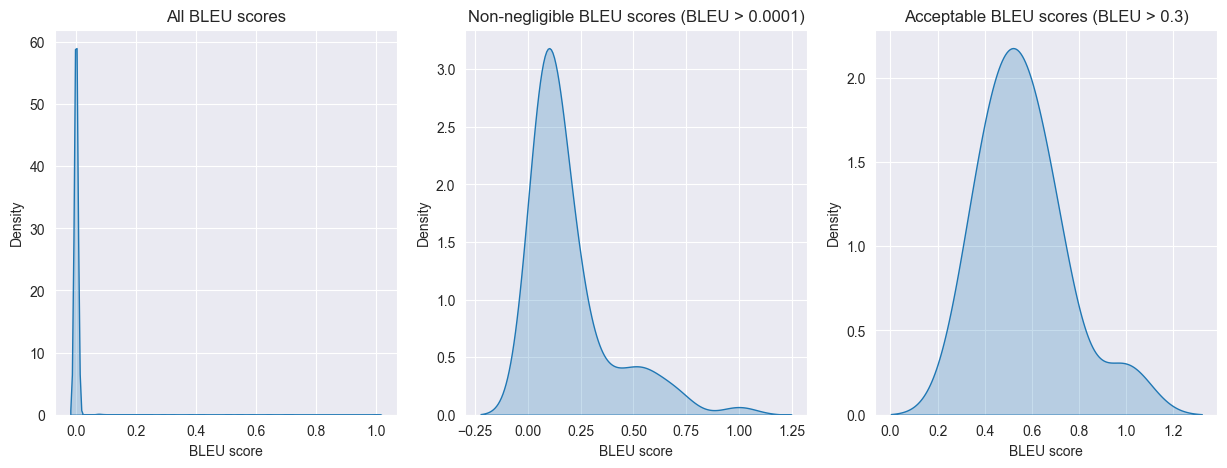

In [79]:
acceptance_threshold = 0.3
epsilon = 0.0001

non_negligible_bleu_scores = [score for score in bleu_classic_scores if score > epsilon]
acceptable = [score for score in bleu_classic_scores if score > acceptance_threshold]

print(f'Number of positive BLEU scores: {len(bleu_classic_scores)}')
print(f'Number of non-negligible BLEU scores: {len(non_negligible_bleu_scores)}')
print(f'Number of acceptable BLEU scores: {len(acceptable)}')

save_path = os.path.join(CURRENT_RESULTS_FOLDER, 'bleu_scores.png')
scores = [bleu_classic_scores, non_negligible_bleu_scores, acceptable]
titles = ['All BLEU scores', f'Non-negligible BLEU scores (BLEU > {epsilon})', f'Acceptable BLEU scores (BLEU > {acceptance_threshold})']
plot_scores(scores, titles, 'BLEU score', save_path=save_path)

### **Best BLEU scores**

In [80]:
def get_ordered_score_indexes(scores, best=True, limit=3):
    return sorted(range(len(scores)), key=lambda i: scores[i], reverse=best)[:limit]

def show_translations(indexes, reference_source, reference_destination, decoded_outputs):
    for idx in indexes:
        print()
        print(f'Index: {idx}')
        print(f'Reference source: {reference_source[idx][:-1]}')
        print(f'Reference destination: {reference_destination[idx][:-1]}')
        print(f'Decoded output: {decoded_outputs[idx]}')
        reference_destination_tokens = set(reference_destination[idx].strip().split(' '))
        decoded_output_tokens = set(decoded_outputs[idx].strip().split(' '))
        print(f'Reference destination tokens: {reference_destination_tokens}')
        print(f'Decoded output tokens: {decoded_output_tokens}')
        overlapping_words = reference_destination_tokens.intersection(decoded_output_tokens)
        print(f'Overlapping words: {overlapping_words}')
        print('------------------')

In [81]:
best_indexes = get_ordered_score_indexes(list(bleu_classic_scores), best=True, limit=10)
show_translations(best_indexes, reference_source_gn, reference_destination_es, decoded_outputs)


Index: 1610
Reference source: pe aranduka morotĩ
Reference destination: el libro es blanco.
Decoded output: el libro es blanco.

Reference destination tokens: {'libro', 'es', 'blanco.', 'el'}
Decoded output tokens: {'libro', 'es', 'blanco.', 'el'}
Overlapping words: {'libro', 'es', 'blanco.', 'el'}
------------------

Index: 2717
Reference source: OÑEMBOSAKO'I AMANDAJE GUASU ÑE'Ẽ RAPEREKA PARAGUÁIPE REHEGUA.
Reference destination: ORGANIZAN II SEMINARIO-TALLER SOBRE INVESTIGACIÓN LINGŨÍSTICA EN PARAGUAY.
Decoded output: SEMINARIO-TALLER SOBRE INVESTIGACIÓN LINGŨÍSTICA EN PARAGUAY.

Reference destination tokens: {'LINGŨÍSTICA', 'INVESTIGACIÓN', 'ORGANIZAN', 'EN', 'II', 'PARAGUAY.', 'SOBRE', 'SEMINARIO-TALLER'}
Decoded output tokens: {'LINGŨÍSTICA', 'INVESTIGACIÓN', 'EN', 'PARAGUAY.', 'SOBRE', 'SEMINARIO-TALLER'}
Overlapping words: {'LINGŨÍSTICA', 'INVESTIGACIÓN', 'EN', 'PARAGUAY.', 'SOBRE', 'SEMINARIO-TALLER'}
------------------

Index: 4024
Reference source: TEMBIAPORÃ'ATY “ROHAYHU CH

In [82]:
best_indexes = get_ordered_score_indexes(list(sacrebleu_scores), best=True, limit=10)
show_translations(best_indexes, reference_source_gn, reference_destination_es, decoded_outputs)


Index: 1610
Reference source: pe aranduka morotĩ
Reference destination: el libro es blanco.
Decoded output: el libro es blanco.

Reference destination tokens: {'libro', 'es', 'blanco.', 'el'}
Decoded output tokens: {'libro', 'es', 'blanco.', 'el'}
Overlapping words: {'libro', 'es', 'blanco.', 'el'}
------------------

Index: 4024
Reference source: TEMBIAPORÃ'ATY “ROHAYHU CHE ÑE'Ẽ” 2017 REHEGUA
Reference destination: AGENDA DE ACTIVIDADES DE “ROHAYHU CHE ÑE'Ẽ” 2017
Decoded output: AGENDA DE ACTIVIDADES DE “ROHAYHU CHE ÑE'Ẽ”.

Reference destination tokens: {'AGENDA', 'ACTIVIDADES', '“ROHAYHU', 'DE', 'CHE', '2017', "ÑE'Ẽ”"}
Decoded output tokens: {'AGENDA', 'ACTIVIDADES', '“ROHAYHU', 'DE', 'CHE', "ÑE'Ẽ”."}
Overlapping words: {'AGENDA', 'ACTIVIDADES', '“ROHAYHU', 'DE', 'CHE'}
------------------

Index: 2717
Reference source: OÑEMBOSAKO'I AMANDAJE GUASU ÑE'Ẽ RAPEREKA PARAGUÁIPE REHEGUA.
Reference destination: ORGANIZAN II SEMINARIO-TALLER SOBRE INVESTIGACIÓN LINGŨÍSTICA EN PARAGUAY.
Decode

Curiosidad: En el índice 3488 confunde la palabra "igualdad" con "nosotros"... ¿Casualidad?

In [83]:
worst_indexes = get_ordered_score_indexes(list(bleu_classic_scores), best=False)
show_translations(worst_indexes, reference_source_gn, reference_destination_es, decoded_outputs)


Index: 0
Reference source: ñemosẽ
Reference destination: Expulsar
Decoded output: deficiencia

Reference destination tokens: {'Expulsar'}
Decoded output tokens: {'deficiencia'}
Overlapping words: set()
------------------

Index: 5
Reference source: Haipy guaraníme ikatúva oñemboguejy reínte
Reference destination: Obras en guaraní para descargar gratis
Decoded output: En el siguiente panel fue un diccionario guaraní.

Reference destination tokens: {'gratis', 'guaraní', 'descargar', 'en', 'para', 'Obras'}
Decoded output tokens: {'un', 'En', 'fue', 'diccionario', 'panel', 'guaraní.', 'siguiente', 'el'}
Overlapping words: set()
------------------

Index: 9
Reference source: Uperiremi neakâguapy
Reference destination: Al rato te calmas
Decoded output: Concluyó diciendo

Reference destination tokens: {'te', 'rato', 'Al', 'calmas'}
Decoded output tokens: {'diciendo', 'Concluyó'}
Overlapping words: set()
------------------


In [84]:
worst_indexes = get_ordered_score_indexes(list(sacrebleu_scores), best=False)
show_translations(worst_indexes, reference_source_gn, reference_destination_es, decoded_outputs)


Index: 0
Reference source: ñemosẽ
Reference destination: Expulsar
Decoded output: deficiencia

Reference destination tokens: {'Expulsar'}
Decoded output tokens: {'deficiencia'}
Overlapping words: set()
------------------

Index: 9
Reference source: Uperiremi neakâguapy
Reference destination: Al rato te calmas
Decoded output: Concluyó diciendo

Reference destination tokens: {'te', 'rato', 'Al', 'calmas'}
Decoded output tokens: {'diciendo', 'Concluyó'}
Overlapping words: set()
------------------

Index: 14
Reference source: Ojehupi pasaje interior gotyo jeho
Reference destination: Reajustan pasajes del interior
Decoded output: “Adefesio” municipal en Avenida Quinta

Reference destination tokens: {'Reajustan', 'pasajes', 'interior', 'del'}
Decoded output tokens: {'“Adefesio”', 'Quinta', 'en', 'Avenida', 'municipal'}
Overlapping words: set()
------------------


### **¿What about the missing line?**

In [85]:
def plot_values_by_index(scores):
    sns.set_style('darkgrid')
    x = list(range(len(scores)))
    y = scores
    plt.plot(x, y)
    plt.show()

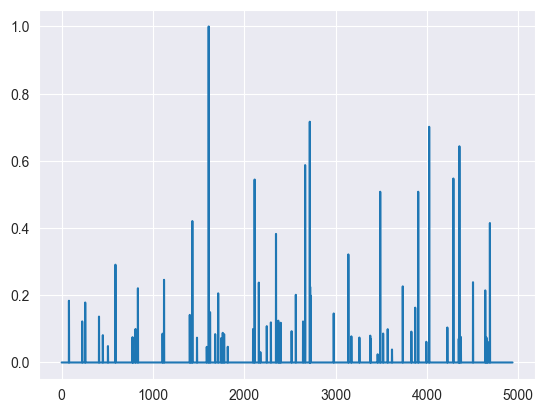

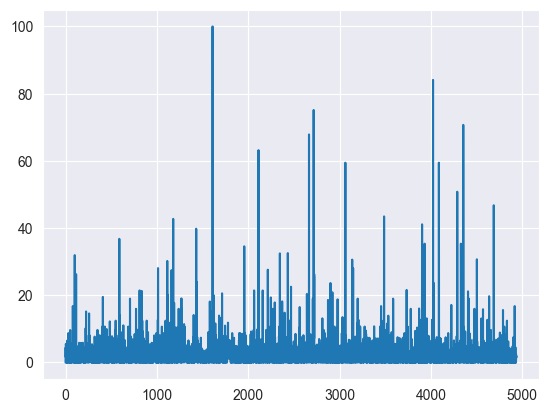

In [86]:
plot_values_by_index(bleu_classic_scores)
plot_values_by_index(sacrebleu_scores)

Nothing seems to indicate that the missing line is causing problems...

Also, there seems to be considerable agreement between the classic BLEU score and SacreBLEU (except from low scores).